<a href="https://colab.research.google.com/github/juanfisicobr/dio_ML/blob/main/transferencia_de_aprendizagem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Transfer Learning no Google Colab

Projeto de Transfer Learning no Google Colab, permite classificar imagens de gatos e cachorros com alta precisão. O desafio começou com a crucial etapa de preparação de dados, onde se baixou, descompactou e organizou o dataset em pastas de treino e validação, superando obstáculos como imagens corrompidas e com canais inconsistentes. Em seguida, se empregou o ImageDataGenerator para carregar eficientemente as imagens, aplicando normalização e técnicas de aumento de dados para aprimorar a robustez do modelo. O coração do projeto foi a aplicação do Transfer Learning, utilizando o modelo MobileNetV2 pré-treinado com as camadas base congeladas (extração de características) e adicionando uma nova camada classificadora personalizada para sua tarefa binária. O modelo foi então compilado e treinado, com a inclusão de callbacks como ModelCheckpoint para salvar a melhor versão e EarlyStopping para otimizar o processo de treinamento e evitar overfitting. O resultado foi impressionante, com o modelo atingindo uma acurácia de validação de 97.50%, demonstrando a eficácia da sua abordagem. Finalmente, se aprendeu a provar seu modelo carregando a versão salva e realizando previsões em novas imagens, validando o sucesso do seu trabalho.


In [17]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras
import shutil

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [7]:
!echo "Download do arquivo kagglecatsanddogs_5340.zip para os notebooks de imagem"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
!file kagglecatsanddogs_5340.zip
!unzip -o kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/55

Definir o diretório raiz das imagens baixadas

In [8]:
original_data_root = 'PetImages'

Definir os diretórios de saída para treino e validação/teste

In [13]:
output_data_root = 'processed_data'
train_dir = os.path.join(output_data_root, 'train')
validation_dir = os.path.join(output_data_root, 'validation')
test_dir = os.path.join(output_data_root, 'test')

Definir as proporções para treino e validação

In [10]:
train_split = 0.8
val_split = 0.2

As categorias (classes) para este dataset são fixas

In [11]:
categories = ['Cat', 'Dog']


Criar os diretórios de destino se não existirem

In [15]:
for directory in [train_dir, validation_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

print(f"Diretórios de destino criados em: {output_data_root}")
print(f"Categorias para processar: {categories}")

Diretórios de destino criados em: processed_data
Categorias para processar: ['Cat', 'Dog']


Processar e copiar as imagens, tratando as corrompidas

In [18]:

corrupted_images_count = 0
for category in categories:
    print(f"\nProcessando categoria: {category}")
    source_path = os.path.join(original_data_root, category)
    images = [os.path.join(source_path, img) for img in os.listdir(source_path)]
    random.shuffle(images) # Embaralhar as imagens para garantir uma divisão aleatória

    # Filtrar imagens corrompidas (exemplo usando um try-except para abrir a imagem)
    # Para datasets como esse, é comum encontrar arquivos .db que não são imagens
    valid_images = []
    for img_path in images:
        # Ignora arquivos de sistema como .DS_Store
        if os.path.basename(img_path).startswith('.'):
            continue
        # Tenta abrir a imagem para verificar se está corrompida
        try:
            from PIL import Image
            img = Image.open(img_path)
            img.verify() # Verifica a integridade do arquivo de imagem
            valid_images.append(img_path)
        except Exception as e:
            # print(f"AVISO: Imagem corrompida ou inválida encontrada e ignorada: {img_path} ({e})")
            corrupted_images_count += 1
            # Você pode mover essas imagens para uma pasta de quarentena se quiser
            # os.remove(img_path) # Ou remover diretamente, com cautela

    print(f"Total de imagens válidas para {category}: {len(valid_images)}")

    # Calcular os tamanhos das divisões
    num_total = len(valid_images)
    num_train = int(num_total * train_split)
    num_val = int(num_total * val_split)
    # num_test = num_total - num_train - num_val # Se estivesse usando um conjunto de teste

    # Copiar as imagens para os diretórios de destino
    for i, img_path in enumerate(valid_images):
        if i < num_train:
            destination_path = os.path.join(train_dir, category, os.path.basename(img_path))
        elif i < num_train + num_val:
            destination_path = os.path.join(validation_dir, category, os.path.basename(img_path))
        # else: # Se estivesse usando um conjunto de teste
        #     destination_path = os.path.join(test_dir, category, os.path.basename(img_path))

        shutil.copyfile(img_path, destination_path)

print(f"\nProcessamento concluído. Total de imagens corrompidas/inválidas encontradas: {corrupted_images_count}")
print(f"Estrutura final criada em '{output_data_root}' com divisões de treino e validação.")

# Verifique o número de imagens em cada pasta
print("\nContagem final de imagens:")
for split_dir in [train_dir, validation_dir]:
    for category in categories:
        path = os.path.join(split_dir, category)
        count = len(os.listdir(path))
        print(f"{split_dir.split('/')[-1]}/{category}: {count} imagens")



Processando categoria: Cat
Total de imagens válidas para Cat: 12499

Processando categoria: Dog


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total de imagens válidas para Dog: 12499

Processamento concluído. Total de imagens corrompidas/inválidas encontradas: 4
Estrutura final criada em 'processed_data' com divisões de treino e validação.

Contagem final de imagens:
train/Cat: 9999 imagens
train/Dog: 9999 imagens
validation/Cat: 2499 imagens
validation/Dog: 2499 imagens


Definir os parâmetros para carregar as imagens

In [20]:
import tensorflow as tf

IMAGE_SIZE = (160, 160) # Tamanho que as imagens serão redimensionadas.
                       # Modelos pré-treinados como MobileNetV2 geralmente usam 224x224 ou 160x160.
                       # Vamos usar 160x160 aqui como um exemplo.
BATCH_SIZE = 32        # Número de imagens processadas por vez durante o treinamento

# Caminhos para seus dados organizados
train_dir = 'processed_data/train'
validation_dir = 'processed_data/validation'

# --- Carregar o dataset de Treino ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',          # As labels são inferidas a partir dos nomes das subpastas (Cat, Dog)
    label_mode='binary',        # Para duas classes (Cat, Dog), 'binary' (0 ou 1) é ideal
    image_size=IMAGE_SIZE,      # Redimensiona todas as imagens para este tamanho
    interpolation='nearest',    # Método de interpolação ao redimensionar
    batch_size=BATCH_SIZE,      # Tamanho do batch
    shuffle=True,               # Embaralhar os dados de treino é importante
    seed=42                     # Para reprodutibilidade do embaralhamento
)

# --- Carregar o dataset de Validação ---
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',          # As labels são inferidas a partir dos nomes das subpastas
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False,              # Não é necessário embaralhar dados de validação
    seed=42                     # Para reprodutibilidade
)

# --- Verificar as classes inferidas ANTES de aplicar .cache() e .prefetch() ---
# class_names é uma propriedade do dataset retornado por image_dataset_from_directory
class_names = train_dataset.class_names
print(f"Nomes das classes inferidas: {class_names}") # Deve ser ['Cat', 'Dog'] ou similar

# --- Preparar os datasets para melhor performance ---
# O método .cache() mantém as imagens na memória após a primeira leitura, acelerando as épocas.
# O método .prefetch() pré-busca os próximos batches enquanto o GPU está processando o atual.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# --- Verificar um exemplo de batch (pode ser feito depois do cache/prefetch) ---
for images, labels in train_dataset.take(1): # Pega um batch de exemplo
    print(f"Shape de um batch de imagens: {images.shape}") # (BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    print(f"Shape de um batch de labels: {labels.shape}")   # (BATCH_SIZE,)
    print(f"Tipo de dado das imagens: {images.dtype}")
    print(f"Tipo de dado das labels: {labels.dtype}")
    break # Sai do loop após pegar o primeiro batch

Found 19998 files belonging to 2 classes.
Found 4998 files belonging to 2 classes.
Nomes das classes inferidas: ['Cat', 'Dog']
Shape de um batch de imagens: (32, 160, 160, 3)
Shape de um batch de labels: (32, 1)
Tipo de dado das imagens: <dtype: 'uint8'>
Tipo de dado das labels: <dtype: 'float32'>


In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

# Importante: Certifique-se de que IMAGE_SIZE e BATCH_SIZE foram definidos como na etapa anterior.
# Se você estiver executando este bloco de código separadamente, defina-os novamente:
# IMAGE_SIZE = (160, 160)
# BATCH_SIZE = 32

# --- 1. Carregar o Modelo Base Pré-treinado ---
# Carregamos o MobileNetV2 sem as camadas finais de classificação (include_top=False).
# Isso nos dá a base convolucional do modelo, que já aprendeu a extrair características de imagens.
# weights='imagenet' carrega os pesos treinados no dataset ImageNet.
base_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), # O input_shape deve ser (altura, largura, canais)
                         include_top=False,            # Não inclui a camada de classificação final
                         weights='imagenet')

# --- 2. Congelar as Camadas do Modelo Base ---
# Isso é crucial para o Transfer Learning (Feature Extraction).
# Ao congelar as camadas, os pesos do modelo pré-treinado não serão atualizados durante o treinamento.
# Isso evita que as características já aprendidas sejam "desaprendidas" em um dataset menor.
base_model.trainable = False

# --- 3. Construir o Novo Classificador em Cima do Modelo Base ---
# Adicionamos novas camadas que serão treinadas do zero para o seu problema específico (gatos vs. cachorros).

# Pegar a saída do modelo base
x = base_model.output

# Adicionar uma camada de pooling global para achatar as características
# (converte blocos de características em um único vetor para cada imagem)
x = GlobalAveragePooling2D()(x)

# Adicionar uma camada densa (fully connected) para processar as características
# Você pode adicionar mais camadas Dense aqui, se quiser
# x = Dense(128, activation='relu')(x) # Exemplo de camada adicional

# A camada de saída para sua classificação binária (gato ou cachorro)
# Como label_mode='binary' retorna 0 ou 1, usamos uma unidade e ativação 'sigmoid'
predictions = Dense(1, activation='sigmoid')(x)

# --- 4. Criar o Modelo Final ---
# Este é o modelo que você irá treinar. Ele consiste no modelo base pré-treinado (congelado)
# e suas novas camadas de classificação.
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. Mostrar um Resumo do Modelo ---
# Isso é útil para ver a arquitetura do seu novo modelo,
# incluindo as camadas congeladas e as novas camadas treináveis.
model.summary()

# --- Verificação Adicional (Opcional) ---
# Verifique quantos pesos são treináveis (devem ser apenas os da nova cabeça de classificação)
print(f"\nNúmero de camadas treináveis no modelo base: {len(base_model.trainable_variables)}")
print(f"Número total de camadas treináveis no modelo final: {len(model.trainable_variables)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Número de camadas treináveis no modelo base: 0
Número total de camadas treináveis no modelo final: 2


Nomes das classes inferidas: ['Cat', 'Dog']
Found 19998 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Número de camadas treináveis no modelo base: 0
Número total de camadas treináveis no modelo final: 2

Iniciando o treinamento do modelo...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9310 - loss: 0.1738

625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 244ms/step - accuracy: 0.9310 - loss: 0.1738 - val_accuracy: 0.9750 - val_loss: 0.0687
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 231ms/step - accuracy: 0.9590 - loss: 0.1013 - val_accuracy: 0.9674 - val_loss: 0.0880
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.9629 - loss: 0.0929 - val_accuracy: 0.9684 - val_loss: 0.0856
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.9625 - loss: 0.0923 - val_accuracy: 0.9648 - val_loss: 0.0934
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.9666 - loss: 0.0866 - val_accuracy: 0.9728 - val_loss: 0.0736
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.9640 - loss: 0.0912 - val_accuracy: 0.9732 - val_loss: 0.0669

Treinamento concluído!
O melhor modelo foi salvo em: best_model_transfer_learning.h5

Avaliando o modelo final no conjunto de validação:
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9716 - loss: 0.0740
Loss 

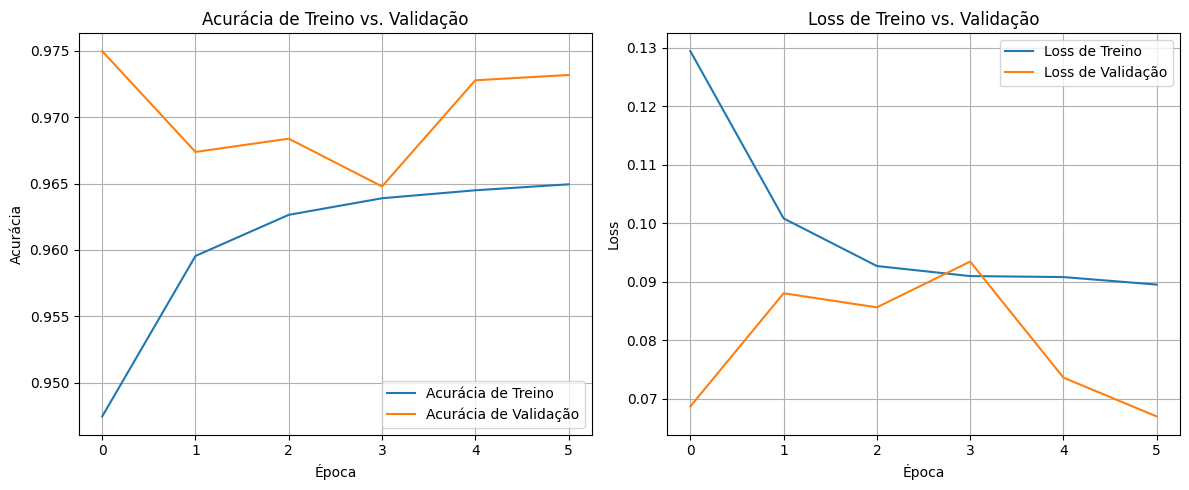

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os # Importar os para manipulação de caminhos

# --- 1. Definir os Parâmetros e Caminhos ---
# Parâmetros de imagem e batch (como no seu código anterior)
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

# Caminhos para seus dados organizados
train_dir = 'processed_data/train'
validation_dir = 'processed_data/validation'

# As categorias (nomes das subpastas)
class_names = sorted(os.listdir(train_dir)) # Deve ser ['Cat', 'Dog'] ou ['Dog', 'Cat']
print(f"Nomes das classes inferidas: {class_names}")

# --- 2. Normalização e Aumento de Dados (Data Augmentation) com ImageDataGenerator ---
# Conforme o notebook de exemplo, as imagens precisam ser normalizadas.
# ImageDataGenerator pode fazer isso para nós (rescale=1./255).
# Ele também pode aplicar aumento de dados para melhorar a robustez do modelo.

# Gerador para dados de treinamento (com aumento de dados)
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=20,              # Rotaciona imagens em até 20 graus
    width_shift_range=0.2,          # Desloca imagens horizontalmente
    height_shift_range=0.2,         # Desloca imagens verticalmente
    shear_range=0.2,                # Aplica transformação de cisalhamento
    zoom_range=0.2,                 # Aplica zoom aleatório
    horizontal_flip=True,           # Vira imagens horizontalmente
    fill_mode='nearest'             # Preenche pixels novos criados por transformações
)

# Gerador para dados de validação (apenas normalização, sem aumento de dados)
validation_datagen = ImageDataGenerator(rescale=1./255)

# --- 3. Carregar as Imagens dos Diretórios usando flow_from_directory ---
# A função flow_from_directory lê as imagens das pastas e as redimensiona.
# target_size: o tamanho para o qual as imagens serão redimensionadas.
# class_mode: 'binary' para classificação binária.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42 # Para reprodutibilidade
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False, # Não embaralhar validação
    seed=42 # Para reprodutibilidade
)

# --- 4. Carregar e Configurar o Modelo Base (MobileNetV2) ---
# Conforme o seu código e o modelo de exemplo
base_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

# Congelar as camadas do modelo base (Feature Extraction)
base_model.trainable = False

# --- 5. Construir o Novo Classificador ---
# Adicionar GlobalAveragePooling2D e a camada Dense de saída
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x) # 1 unidade para classificação binária, sigmoid

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Exibir resumo do modelo
model.summary()
print(f"\nNúmero de camadas treináveis no modelo base: {len(base_model.trainable_variables)}")
print(f"Número total de camadas treináveis no modelo final: {len(model.trainable_variables)}")


# --- 6. Compilar o Modelo ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 7. Definir Callbacks ---
checkpoint_filepath = 'best_model_transfer_learning.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

EPOCHS = 10 # Número de épocas para o treinamento

# --- 8. Treinar o Modelo ---
print("\nIniciando o treinamento do modelo...")
history = model.fit(
    train_generator,       # Usar o generator de treino
    epochs=EPOCHS,
    validation_data=validation_generator, # Usar o generator de validação
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("\nTreinamento concluído!")
print(f"O melhor modelo foi salvo em: {checkpoint_filepath}")

# --- 9. Avaliar e Plotar o Histórico ---
print("\nAvaliando o modelo final no conjunto de validação:")
loss, accuracy = model.evaluate(validation_generator)
print(f"Loss da validação: {loss:.4f}")
print(f"Acurácia da validação: {accuracy:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia de Treino vs. Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Loss de Treino vs. Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Modelo carregado com sucesso!

Por favor, faça o upload de uma imagem (de gato ou cachorro) para testar:


Saving hi5i22ws.png to hi5i22ws.png
Shape da imagem pré-processada para predição: (1, 160, 160, 3)


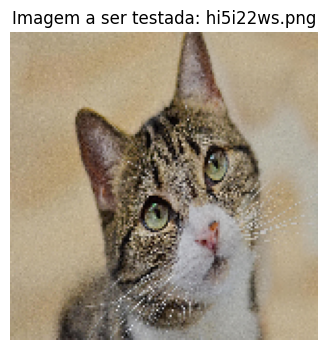

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Saída bruta da predição: [[0.00016399]]

--- Resultado da Predição ---
A imagem é provavelmente um(a): **Cat**
Com **99.98% de confiança**.
(Probabilidade de ser 'Cachorro': 0.02%, Probabilidade de ser 'Gato': 99.98%)


In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files # Necessário para o upload de arquivos

# --- 1. Carregar o Modelo Salvo ---
model_path = 'best_model_transfer_learning.h5'
model = load_model(model_path)
print("Modelo carregado com sucesso!")

# --- 2. Preparar uma Nova Imagem para Teste (Opção: Upload do computador) ---
IMAGE_SIZE = (160, 160)

# Função para carregar e pré-processar a imagem
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Adiciona a dimensão do batch
    img_array /= 255.0 # Normaliza para [0, 1]

    # Garante 3 canais RGB para imagens que podem ter 1 (escala de cinza) ou 4 (RGBA)
    if img_array.shape[-1] == 1: # Escala de cinza
        img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[-1] == 4: # RGBA
        img_array = img_array[:, :, :, :3]

    return img_array

print("\nPor favor, faça o upload de uma imagem (de gato ou cachorro) para testar:")
uploaded = files.upload()

# Obtém o nome do arquivo que foi feito upload
test_image_name = list(uploaded.keys())[0]
test_image_path = test_image_name # O arquivo estará no diretório raiz do Colab

processed_image = load_and_preprocess_image(test_image_path, IMAGE_SIZE)
print(f"Shape da imagem pré-processada para predição: {processed_image.shape}")

# Visualizar a imagem
plt.figure(figsize=(4, 4))
plt.imshow(processed_image[0]) # [0] para remover a dimensão do batch e mostrar a imagem
plt.title(f"Imagem a ser testada: {os.path.basename(test_image_path)}")
plt.axis('off')
plt.show()

# --- 3. Fazer a Predição ---
prediction = model.predict(processed_image)
print(f"Saída bruta da predição: {prediction}")

# Nomes das classes inferidas (geralmente 'Cat' como 0 e 'Dog' como 1 se forem ordenadas alfabeticamente)
class_names = ['Cat', 'Dog']

predicted_class_index = int(np.round(prediction[0][0])) # Arredonda para 0 ou 1
predicted_class_label = class_names[predicted_class_index]

# A confiança é a probabilidade da classe prevista
confidence_score = prediction[0][0] if predicted_class_index == 1 else (1 - prediction[0][0])

print(f"\n--- Resultado da Predição ---")
print(f"A imagem é provavelmente um(a): **{predicted_class_label}**")
print(f"Com **{confidence_score*100:.2f}% de confiança**.")

# Detalhe das probabilidades
if predicted_class_index == 0:
    print(f"(Probabilidade de ser 'Cachorro': {prediction[0][0]*100:.2f}%, Probabilidade de ser 'Gato': {(1 - prediction[0][0])*100:.2f}%)")
else:
    print(f"(Probabilidade de ser 'Cachorro': {prediction[0][0]*100:.2f}%, Probabilidade de ser 'Gato': {(1 - prediction[0][0])*100:.2f}%)")